In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import numpy as np
from PIL import Image

# Define your image folder path
folder_path = '/content/drive/MyDrive/360 Rocks'


images = []
filenames = []

standard_size = (64, 64)

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg')):

        file_path = os.path.join(folder_path, filename)

        # Load the image, convert to grayscale, and resize
        img = Image.open(file_path).convert('L')
        img_resized = img.resize(standard_size)


        img_data = np.array(img_resized).flatten()


        images.append(img_data)
        filenames.append(filename)


images_array = np.array(images)

print(images_array.shape)

(360, 4096)


**1. Applied PCA to the images from folder '360 Rocks'to preserve 90% of the variance**

In [5]:
from sklearn.decomposition import PCA

# Apply PCA with n_components set to 0.9 to preserve 90% of the variance
pca = PCA(n_components=0.9)
images_pca = pca.fit_transform(images_array)

# The number of components needed to preserve 90% of variance
num_components_90_var = pca.n_components_
print(num_components_90_var)

93


Accoring to the n.components_ variable from the PCA class, the number of components needed to preserve 90% of the variance is 93.

**2. Plotted 10 images in the original form (without PCA) and then plotted their reconstruction (projection in the original space) after having 90% of variance using PCA.**

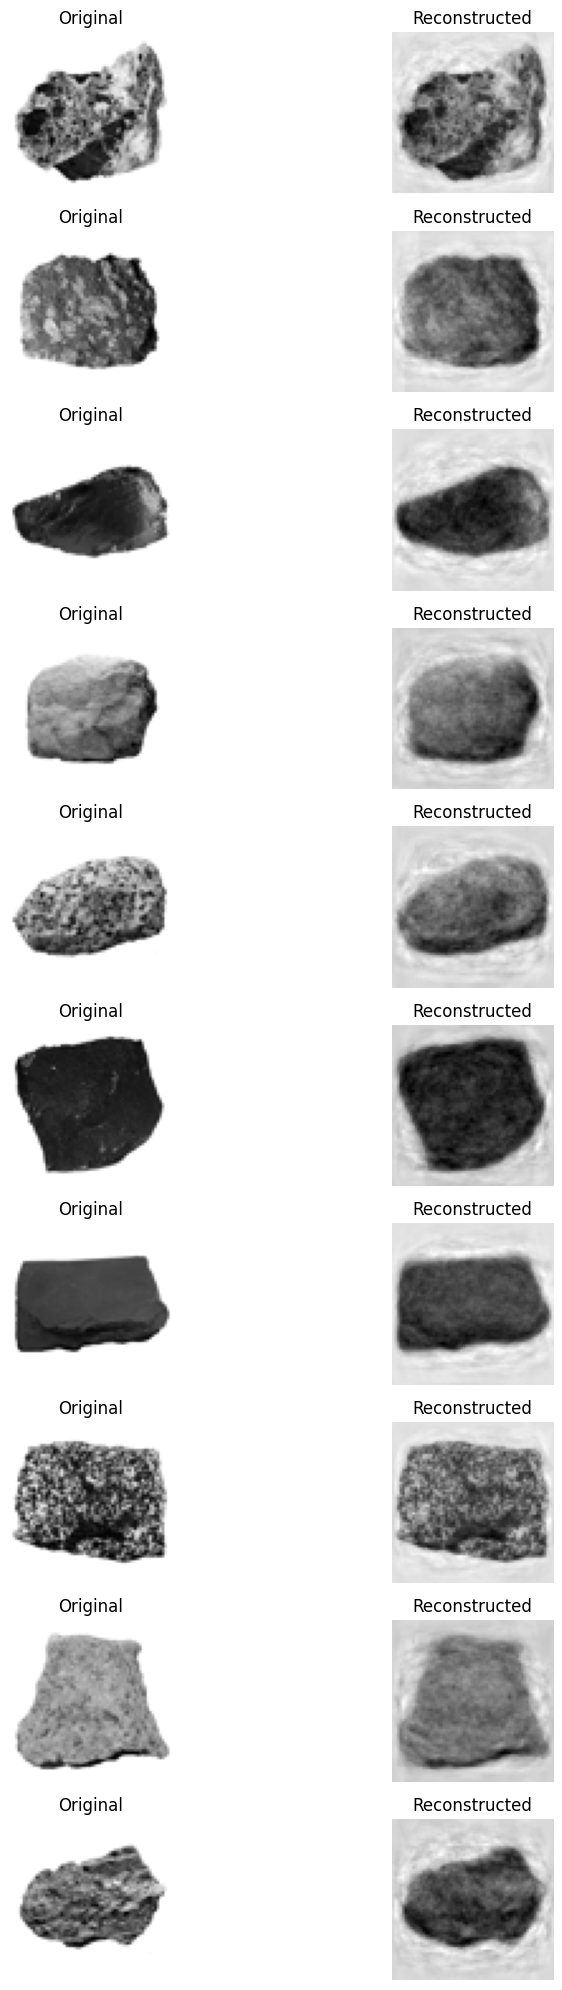

In [6]:
import matplotlib.pyplot as plt

np.random.seed(42)
indices = np.random.choice(images_array.shape[0], 10, replace=False)

images_reconstructed = pca.inverse_transform(images_pca[indices])

# Plot original and reconstructed images side by side
fig, axes = plt.subplots(10, 2, figsize=(10, 20))
for i, index in enumerate(indices):
    # Original image
    axes[i, 0].imshow(images_array[index].reshape(64, 64), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # Reconstructed image
    axes[i, 1].imshow(images_reconstructed[i].reshape(64, 64), cmap='gray')
    axes[i, 1].set_title('Reconstructed')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

**3. Used PCA to reduce dimensionality to only 2 dimensions, to check how much of the variance is explained with the first two principal components?**

In [7]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
images_pca_2d = pca_2d.fit_transform(images_array)

# Calculate the variance explained by the first two components
variance_explained_2d = np.sum(pca_2d.explained_variance_ratio_)

print(f"Variance explained by the first two principal components: {variance_explained_2d*100:.2f}%")

Variance explained by the first two principal components: 38.13%


**Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data. Repeat the process and create the same type of plots for t-SNE, LLE and MDS.**

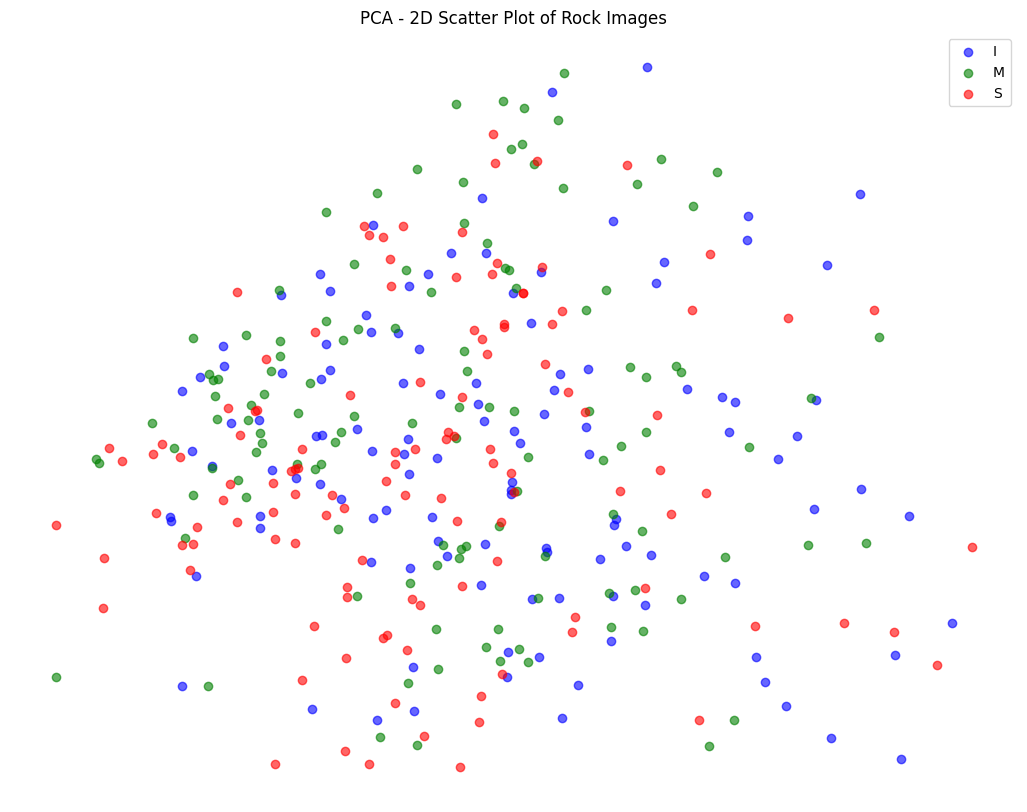

In [8]:
categories = np.array([filename[0] for filename in filenames])  # Assumes filenames list is available

# Mapping categories to colors
category_colors = {'I': 'blue', 'M': 'green', 'S': 'red'}
colors = np.array([category_colors[category] for category in categories])

# Scatter plot
plt.figure(figsize=(13, 10))
for category, color in category_colors.items():
    ix = np.where(categories == category)
    plt.scatter(images_pca_2d[ix, 0], images_pca_2d[ix, 1], c=color, label=category, alpha=0.6)
plt.title('PCA - 2D Scatter Plot of Rock Images')
plt.axis("off")
plt.legend()
plt.show()

Add rock images to 2D PCA Scatter plot

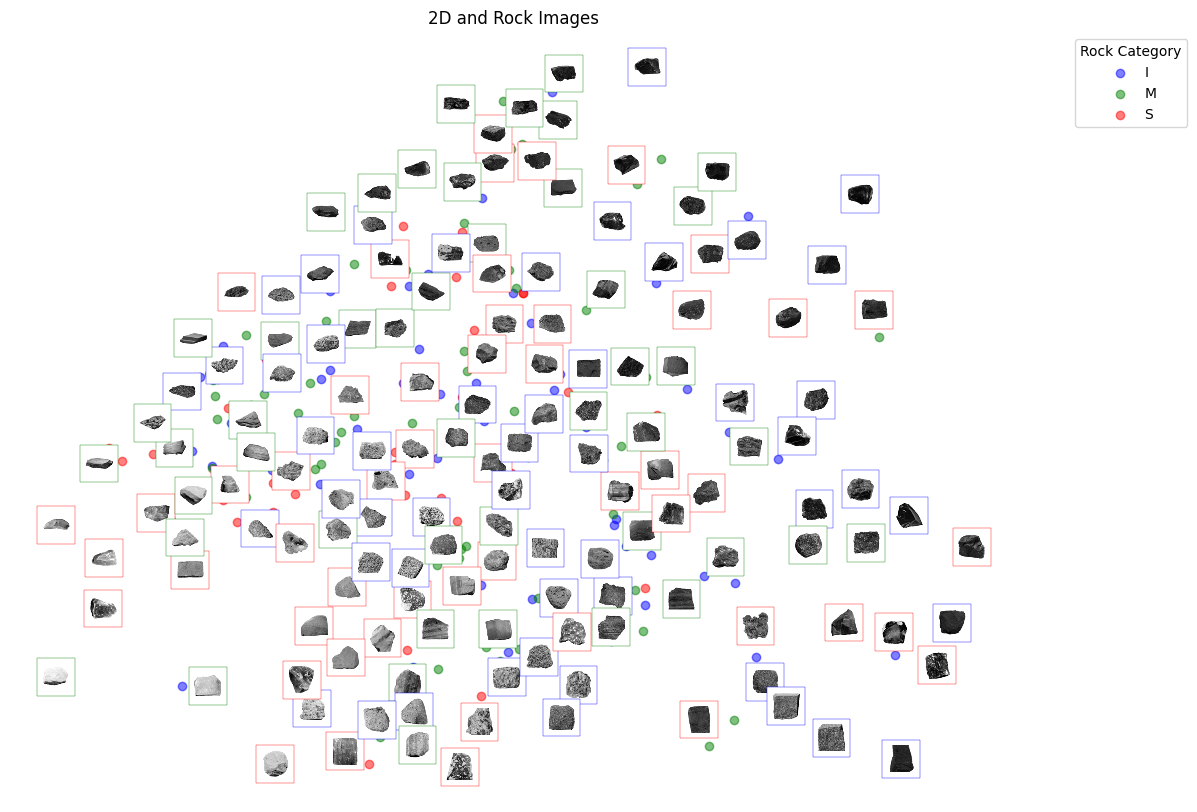

In [9]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_rocks(X, categories, min_distance=0.04, images=None, figsize=(13, 10), image_zoom=0.1):
    # Normalize the PCA features to range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)

    # Define colors for each category
    category_colors = {
        'I': 'blue',
        'M': 'green',
        'S': 'red'
    }


    fig, ax = plt.subplots(figsize=figsize)


    for category in np.unique(categories):
        ax.scatter(X_normalized[categories == category, 0],
                    X_normalized[categories == category, 1],
                    c=category_colors[category], label=category, alpha=0.5)

    plt.axis("off")

    # Adding images with colored frame based on the category
    neighbors = np.array([[10., 10.]])
    for index, image_coord in enumerate(X_normalized):
        category = categories[index]
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is not None:
                image = images[index].reshape(64, 64)
                imagebox = AnnotationBbox(OffsetImage(image, zoom=image_zoom, cmap="gray"),
                                          image_coord, frameon=True,
                                          bboxprops=dict(edgecolor=category_colors[category], linewidth=0.3))
                ax.add_artist(imagebox)


    plt.legend(title='Rock Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('2D and Rock Images')
    plt.show()

plot_rocks(X=images_pca_2d, categories=categories, images=images_array, image_zoom=0.3)

Repeat the same process for t-SNE, LLE and MDS

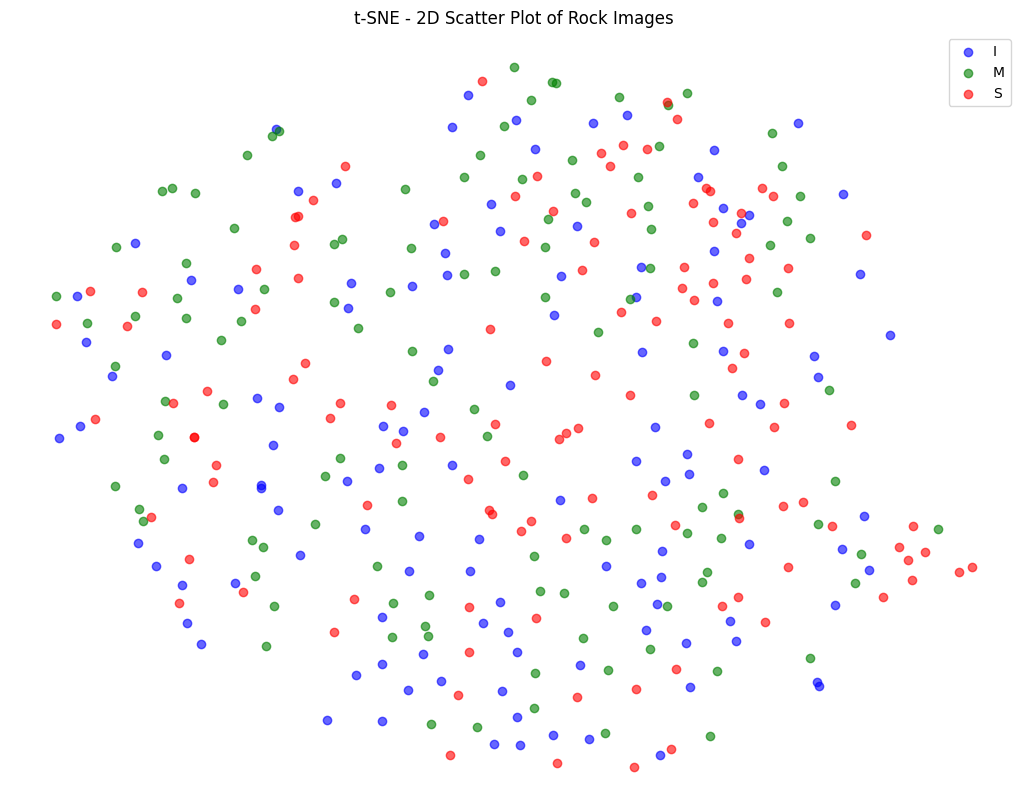

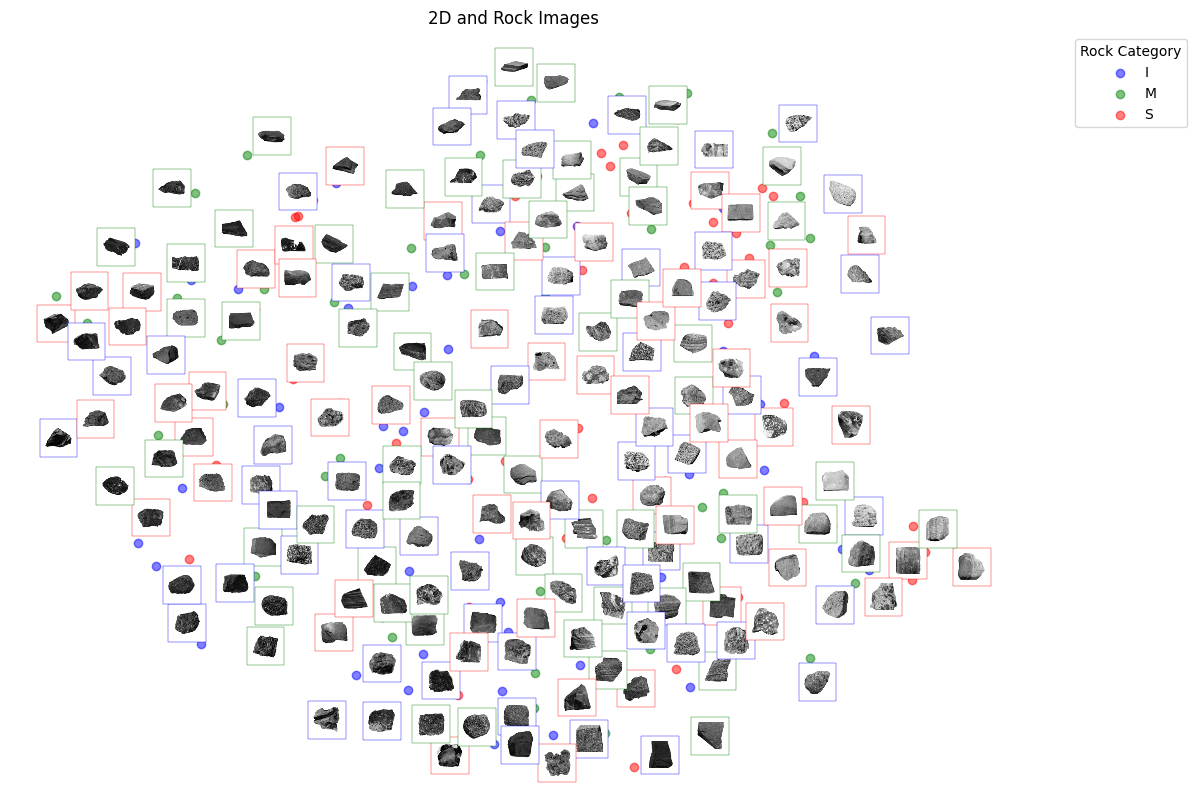

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
tsne_images = tsne.fit_transform(images_array)
plt.figure(figsize=(13, 10))
for category, color in category_colors.items():
    ix = np.where(categories == category)
    plt.scatter(tsne_images[ix, 0], tsne_images[ix, 1], c=color, label=category, alpha=0.6)
plt.title('t-SNE - 2D Scatter Plot of Rock Images')
plt.axis("off")
plt.legend()
plt.show()
print()
plot_rocks(X = tsne_images, categories = categories, images = images_array, image_zoom = 0.3)

**LLE**

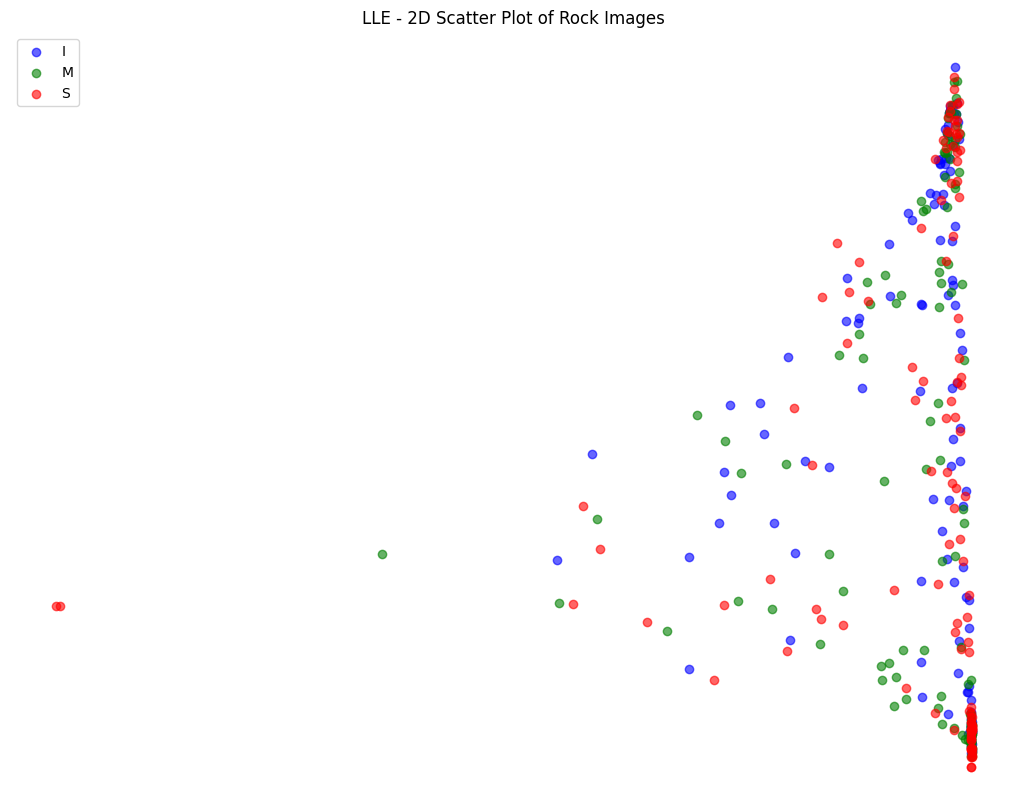

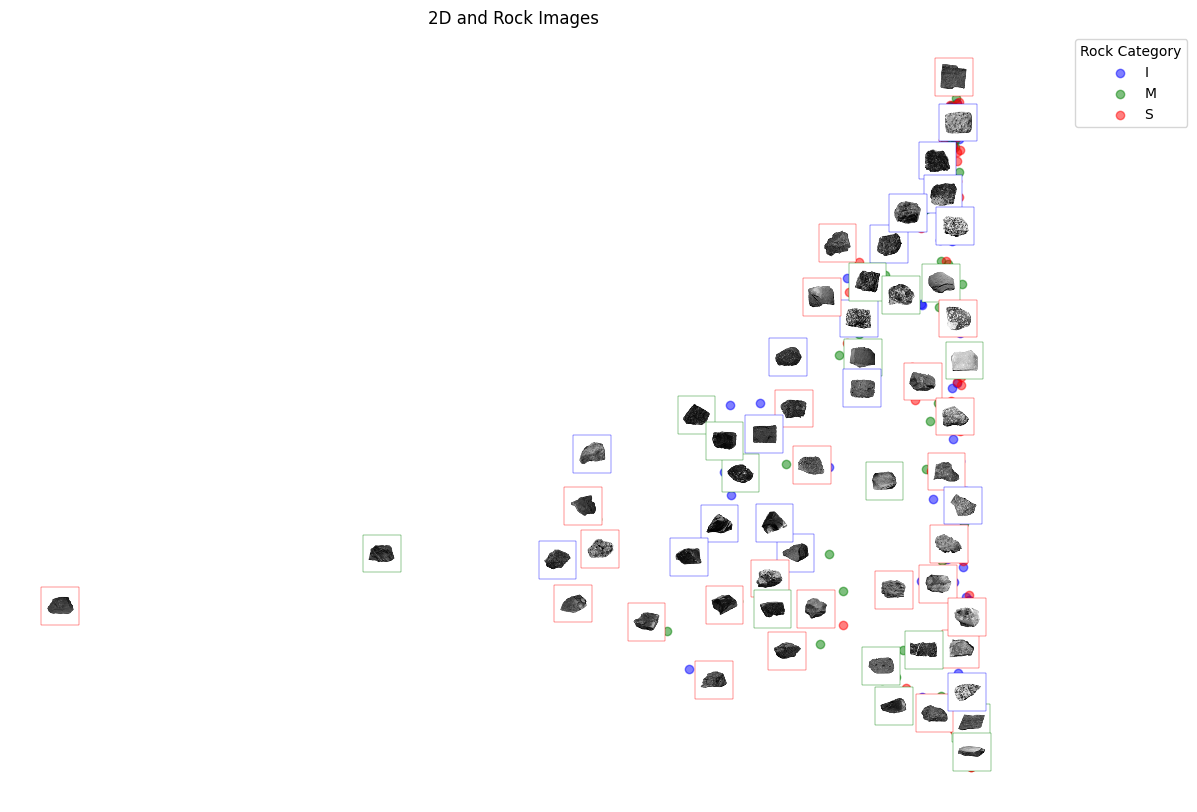

In [11]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, random_state=42)
lle_images = lle.fit_transform(images_array)
plt.figure(figsize=(13, 10))
for category, color in category_colors.items():
    ix = np.where(categories == category)
    plt.scatter(lle_images[ix, 0], lle_images[ix, 1], c=color, label=category, alpha=0.6)
plt.title('LLE - 2D Scatter Plot of Rock Images')
plt.axis("off")
plt.legend()
plt.show()
print()
plot_rocks(X = lle_images, categories = categories, images = images_array, image_zoom = 0.3)

**MDS**

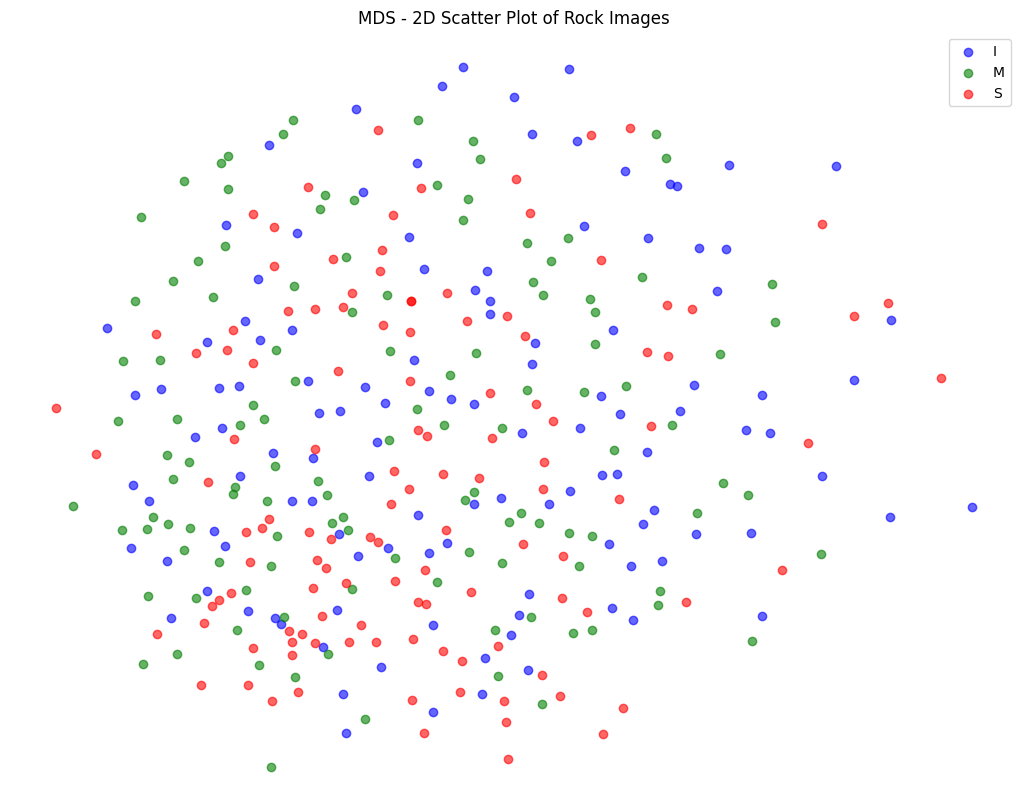

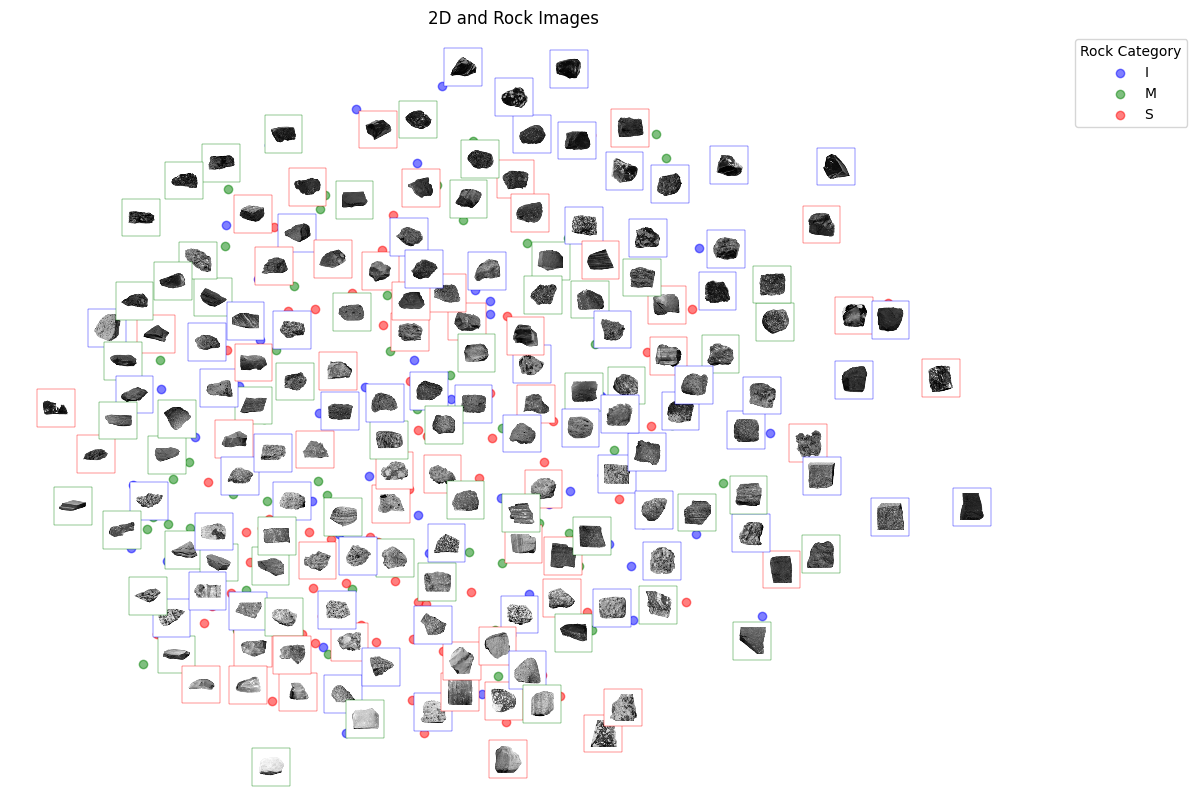

In [12]:
from sklearn.manifold import MDS

mds_images = MDS(n_components=2, normalized_stress=False, random_state=42).fit_transform(images_array)


plt.figure(figsize=(13, 10))
for category, color in category_colors.items():
    ix = np.where(categories == category)
    plt.scatter(mds_images[ix, 0], mds_images[ix, 1], c=color, label=category, alpha=0.6)
plt.title('MDS - 2D Scatter Plot of Rock Images')
plt.axis("off")
plt.legend()
plt.show()
print()
plot_rocks(X = mds_images, categories = categories, images = images_array, image_zoom = 0.3)

# **Discussion:**

**PCA:** The PCA scatter plots shows a relatively even dispersion of points wihtout any distinct clustering. There appear to be a few points that are starting to come together, but they are still very spread out. Since PCA is a linear method, this could indicate that the features separating the rock types might not be linear. After adding the rock images it appears that rocks with similar shape and size are plotted closer to each other but not in a cluster.

**t-SNE:** The plot for t-SNE shows some slight improvement in clustering compared to PCA, particularly with the S category (red dots) on the left side of the plot. However, there is still quite a bit of dispersion and overlap between the categories. After adding images to the plot, it appears that t-SNE is grouping the points together based on color and size/shape, you can clearly see the darker rock images to the top right and the lighter rocks towards the bottom left.

**LLE:** The LLE plot displays a very different structure compared to the others, forming a half hour-glass shape. It appears that there is some clustering of points towards the top right and bottom right, but with significant overlap. The pattern suggests that LLE is preserving local relations. After adding the images, it is still quite hard to determine what features are being used to group the images together. The images in the top right appear to have similar patterns, but those patterns are also visible at other points in the plot.

**MDS:** The MDS plots a dispersion of points similar to PCA, but with more defined clusters. However, these clusters have significant overlap. It appears there is some clustering of the S (red dot) and M (green dot) categories in the top right and top left of the plot with a lot of overlap between them. The I category (blue dot) is dispersed throughout the plot with no apparent clusters.
After adding images to the plot, it appears that MDS is grouping images based on their color and shape, you can see darker images in the bottom left and lighter images in the top right.

Overall, reducing this dataset to two dimensions using any of these techniques does not do a great job in clustering the data. This suggests that the rock categories may require more than two dimensions to be clearly seperated and that the rock images may share similar features across categories making it difficult to cleanly seperate in reduced dimensions.

**4) Now let's see if these dimensionality reduction techniques can give us similar features to those that humans use to judge the images. File mds_360.txt contains 8 features for each of the images (rankings are in the same order as the images in  '360 Rocks' folder. Run PCA, t-SNE, LLE and MDS to reduce the dimensionality of the images to 8. Then, compare those image embeddings with the ones from humans that are in the mds_360.txt file. Use Procrustes analysis to do the comparison (here is one example of how to do that mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data). Here matrix_with_human_data and matrix_with_pca_embeddings_data should be 360 by 8. disparity will tell you the difference in the data.**

In [13]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from scipy.spatial import procrustes
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

human_data = np.loadtxt('/content/drive/MyDrive/mds_360.txt')

pca = PCA(n_components=8)
pca_embeddings = pca.fit_transform(images_array)

tsne = TSNE(n_components=8, random_state=42, method='exact')
tsne_embeddings = tsne.fit_transform(images_array)

lle = LocallyLinearEmbedding(n_components=8)
lle_embeddings = lle.fit_transform(images_array)

mds = MDS(n_components=8, dissimilarity='euclidean')
X_mds = mds.fit_transform(images_array)

disparities = []

mat1_pca, mat1_hd, disparity_pca = procrustes(human_data, pca_embeddings)
disparities.append(disparity_pca)

mat1_tsne, mat2_hd, disparity_tsne = procrustes(human_data, tsne_embeddings)
disparities.append(disparity_tsne)

mat1_lle, mat3_hd, disparity_lle = procrustes(human_data, lle_embeddings)
disparities.append(disparity_lle)

mat1_mds, mat4_hd, disparity_mds = procrustes(human_data, X_mds)
disparities.append(disparity_mds)


print("Disparities:")
print("PCA:", disparity_pca)
print("t-SNE:", disparity_tsne)
print("LLE:", disparity_lle)

Disparities:
PCA: 0.9848299293014884
t-SNE: 0.988154353035493
LLE: 0.9815536283957145


In [14]:
import pandas as pd
corr_pca = np.corrcoef(mat1_pca, mat1_hd)
df_pca = pd.DataFrame(corr_pca,
                  index=[f'PCA{i+1}' for i in range(720)],
                  columns=[f'HD{i+1}' for i in range(720)])

corr_tsne = np.corrcoef(mat1_tsne, mat2_hd)
df_tsne = pd.DataFrame(corr_tsne,
                  index=[f'TSNE{i+1}' for i in range(720)],
                  columns=[f'HD{i+1}' for i in range(720)])

corr_lle = np.corrcoef(mat1_lle, mat1_hd)
df_lle = pd.DataFrame(corr_lle,
                  index=[f'LLE{i+1}' for i in range(720)],
                  columns=[f'HD{i+1}' for i in range(720)])

corr_mds = np.corrcoef(mat1_mds, mat1_hd)
df_mds = pd.DataFrame(corr_mds,
                  index=[f'MDS{i+1}' for i in range(720)],
                  columns=[f'HD{i+1}' for i in range(720)])
print("Correlations: ")
print(df_pca, df_tsne, df_lle, df_mds)

Correlations: 
             HD1       HD2       HD3       HD4       HD5       HD6       HD7  \
PCA1    1.000000  0.315264 -0.141130 -0.091903  0.018005  0.171807 -0.162448   
PCA2    0.315264  1.000000  0.259363  0.712392  0.262746  0.529451  0.043359   
PCA3   -0.141130  0.259363  1.000000  0.131149  0.578990  0.752217  0.597220   
PCA4   -0.091903  0.712392  0.131149  1.000000  0.395812  0.383492  0.437497   
PCA5    0.018005  0.262746  0.578990  0.395812  1.000000  0.849277  0.686923   
...          ...       ...       ...       ...       ...       ...       ...   
PCA716  0.333588  0.359489 -0.240315  0.553393 -0.063838 -0.064745  0.290915   
PCA717 -0.268697 -0.214910 -0.582030  0.182587 -0.444540 -0.693073  0.055102   
PCA718 -0.403532 -0.300281 -0.211175  0.182197 -0.228747 -0.428402  0.367047   
PCA719  0.052183 -0.105085 -0.768025 -0.074734 -0.535623 -0.451840 -0.767441   
PCA720 -0.444815 -0.138725 -0.329887  0.421910 -0.262679 -0.544868  0.320450   

             HD8       H

**Correlations:**

* Correlation coefficients measure the linear relationship between embeddings produced by dimensionality reduction techniques and human perceptual data. Higher correlation coefficients indicate better alignment with human perception.
* Each correlation matrix (df_pca, df_tsne, df_lle, df_mds) shows the correlation coefficients between the embeddings produced by a specific technique and the human perceptual data.
* For example, in the PCA correlation matrix (df_pca), the entry at row PCAi and column HDj represents the correlation coefficient between the ith principal component of PCA embeddings and the jth dimension of human perceptual data.


**Discussion:**

* Comparing the disparities and correlation coefficients across different dimensionality reduction techniques can provide insights into which technique best captures the underlying structure of the data as perceived by humans.
* Lower disparities and higher correlation coefficients suggest that the embeddings produced by a particular technique are more faithful representations of human perception.
* However, correlation coefficients indicate linear relationships, they may not capture all aspects of similarity between embeddings and human perception.


**5) Cluster the 360 images using K-Means.**

**A) You can reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance.**

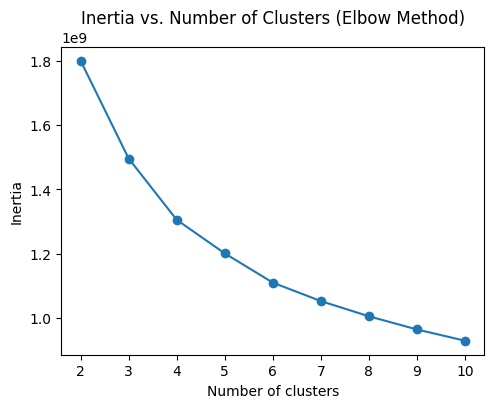

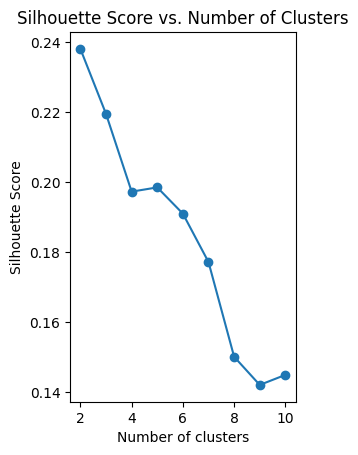

Optimal number of clusters (based on Inertia): 2
Optimal number of clusters (based on Silhouette Score): 2


In [15]:
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_values = []
silhouette_values = []
min_clusters = 2
max_clusters = 10

for n_clusters in range(min_clusters, max_clusters+1):
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(pca_embeddings)
    inertia_values.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(pca_embeddings, cluster_labels)
    silhouette_values.append(silhouette_avg)

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
# Plotting Inertia vs. Number of Clusters
plt.plot(range(min_clusters, max_clusters+1), inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs. Number of Clusters (Elbow Method)')
plt.show()

plt.subplot(1, 2, 2)
# Plotting Silhouette Score vs. Number of Clusters
plt.plot(range(min_clusters, max_clusters+1), silhouette_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

optimal_num_clusters_inertia = np.argmin(np.diff(inertia_values)) + min_clusters
print(f"Optimal number of clusters (based on Inertia): {optimal_num_clusters_inertia}")

optimal_num_clusters_silhouette = np.argmax(silhouette_values) + min_clusters
print(f'Optimal number of clusters (based on Silhouette Score): {optimal_num_clusters_silhouette}')


**Inertia vs. Number of Clusters (Elbow Method):**

* Inertia measures the within-cluster variance, and the elbow method looks for the point where the rate of decrease of inertia slows down (elbow point). This point signifies where adding more clusters doesn't explain much more of the variance. In the plot, the optimal number of clusters is typically where the inertia starts to decrease at a slower rate (elbow).
* In this case, the elbow point appears to be at 2 clusters.

**Silhouette Score vs. Number of Clusters:**

* The silhouette score measures how similar an object is to its own cluster compared to other clusters. The value ranges from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, the clustering configuration is appropriate.
* The optimal number of clusters is where the silhouette score is highest.
* In this case, the silhouette score is highest at 2 clusters.

**B) Set the number of clusters to 3 and check clustering accuracy.**

In [16]:
file_names = os.listdir(folder_path)

images = []
true_labels = []

for file_name in file_names:
    if file_name.endswith('.jpg') or file_name.endswith('.png'):
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path)
        images.append(np.array(image))

        label = file_name.split('_')[0]
        true_labels.append(label)

# images_array = np.array(images)
true_labels_array = np.array(true_labels)

print("Images shape:", images_array.shape)
print("True labels:", true_labels_array[:10])

Images shape: (360, 4096)
True labels: ['M' 'M' 'I' 'I' 'M' 'M' 'I' 'S' 'S' 'I']


In [17]:
silhouette_scores = []
kmeans = KMeans(n_clusters=3)
cluster_labels = kmeans.fit_predict(pca_embeddings)
silhouette = silhouette_score(pca_embeddings, cluster_labels)
print("silhouette score:", silhouette)


silhouette score: 0.2195359610970211


**Discussion:**  
The silhouette score of approximately 0.22 suggests a moderate level of separation between clusters in the dataset. While the clustering algorithm has partitioned the data into three clusters, the degree of distinction between these clusters is not very pronounced, indicating some overlap between them. This score, while indicative of some clustering structure, may not be sufficient for certain applications where clearer separation between clusters is desired. Further exploration, including visual inspection of clusters and experimentation with different clustering configurations or preprocessing techniques, is recommended to improve clustering performance and gain deeper insights into the underlying data structure, ensuring that clustering results align with the specific requirements and objectives of the application at hand.

**6) Cluster the 360 images using EM.**

**A) You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance.**

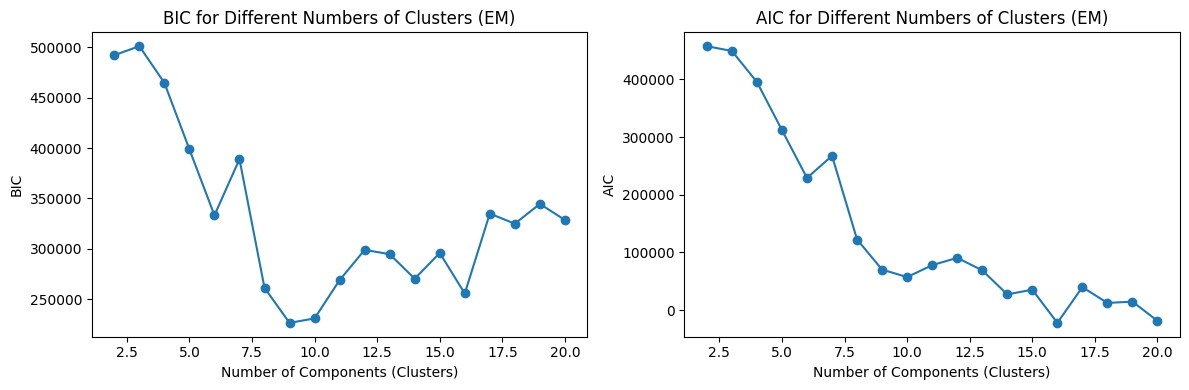

Optimal number of components using BIC: 9
Optimal number of components using AIC: 16


In [18]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

pca = PCA(n_components=0.9)
pca_embeddings = pca.fit_transform(images_array)

BIC = []
AIC = []

min_clusters = 2
max_clusters = 20
for n_clusters in range(min_clusters, max_clusters+1):
    em = GaussianMixture(n_components=n_clusters)
    cluster_labels = em.fit_predict(pca_embeddings)
    BIC.append(em.bic(pca_embeddings))
    AIC.append(em.aic(pca_embeddings))


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(min_clusters,max_clusters+1), BIC, marker='o')
plt.title('BIC for Different Numbers of Clusters (EM)')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('BIC')

plt.subplot(1, 2, 2)
plt.plot(range(min_clusters,max_clusters+1), AIC, marker='o')
plt.title('AIC for Different Numbers of Clusters (EM)')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('AIC')

plt.tight_layout()
plt.show()

optimal_num_components_bic = range(min_clusters,max_clusters+1)[np.argmin(BIC)]
optimal_num_components_aic = range(min_clusters,max_clusters+1)[np.argmin(AIC)]

print(f'Optimal number of components using BIC: {optimal_num_components_bic}')
print(f'Optimal number of components using AIC: {optimal_num_components_aic}')


In [19]:
em = GaussianMixture(n_components=optimal_num_components_bic)
cluster_labels = em.fit_predict(pca_embeddings)
silhouette_avg_gmm = silhouette_score(pca_embeddings, cluster_labels)
print("The average silhouette_score is :", silhouette_avg_gmm)

The average silhouette_score is : 0.06536361340607039


**Discussion:**   
The plots of Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC) for different numbers of clusters in the Gaussian Mixture Model (GMM) reveal optimal numbers of components to be 9 according to BIC and 16 according to AIC. BIC and AIC are both metrics used for model selection, with lower values indicating better model fit while penalizing model complexity. The BIC favors a model with 10 components, suggesting that it balances goodness of fit with parsimony effectively, whereas the AIC favors a more complex model with 19 components. This discrepancy might indicate that the BIC's preference for a simpler model may generalize better, although further examination and possibly domain-specific knowledge are required to determine the most suitable number of components for the dataset at hand.

B) Set the number of clusters to 3 and report clustering accuracy. [

In [20]:
gm=GaussianMixture(n_components=3, n_init=10, random_state=42)
gm_3c = gm.fit_predict(pca_embeddings)
silhouette_avg_3c = silhouette_score(pca_embeddings, gm_3c)
print("The average silhouette_score is :", silhouette_avg_3c)

The average silhouette_score is : 0.14015710605739207


**Discussion:**   
The Gaussian Mixture Model (GMM) with three components yields an average silhouette score of approximately 0.1402. The silhouette score measures the compactness and separation of the clusters formed by the model, with higher scores indicating better-defined clusters. In this case, the score suggests that the clusters are not well-separated and the data points may be closer to the decision boundary between clusters. This lower silhouette score could be due to various factors such as overlapping clusters, uneven cluster sizes, or suboptimal choice of model parameters. It indicates that the model may not be effectively capturing the underlying structure of the data, suggesting the need for further investigation, possibly by experimenting with different numbers of components or exploring alternative clustering techniques.

**c) Used the model to generate 20 new rocks (using the sample() method), and visualize them in the original image space (since used PCA, will need to use its inverse_transform() method).**

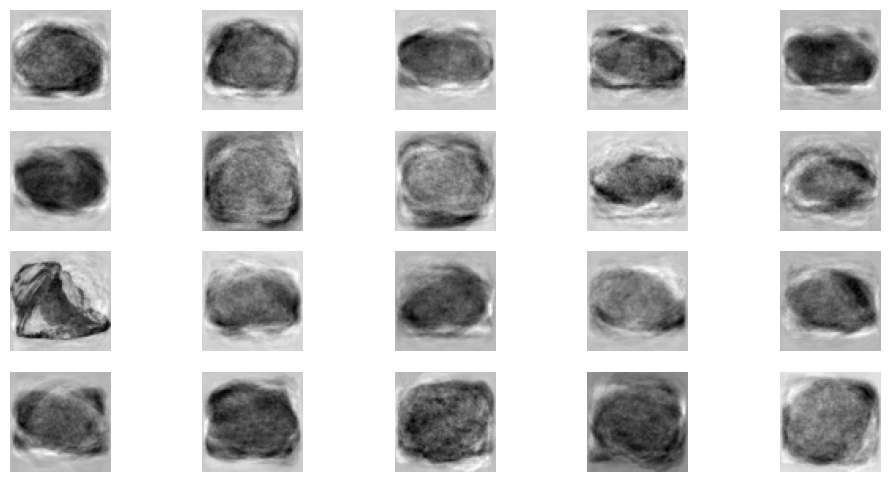

In [21]:
generated_images_pca = em.sample(n_samples=20)[0]
generated_images_original = pca.inverse_transform(generated_images_pca)

image_shape = images_array.shape[1:]

plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(generated_images_original[i].reshape(-1, 64), cmap='gray')
    plt.axis('off')
plt.show()

**7) Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on 360 rock images using rock name as the label - the category is indicated by the first letter in the filename (I, M and S).**

Categorizing the Rocks information into y

In [22]:
y=[filename[0] for filename in os.listdir(folder_path)]
# for filename in os.listdir(folder_path):
#   y.append(filename[0])
y = np.array(y)
print(y.shape)

(360,)


In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(images_array,y,test_size=0.3,random_state=42)

Loading Validation data set

In [24]:
import os
import numpy as np
from PIL import Image

# Define your image folder path
valid_path = '/content/drive/MyDrive/120 Rocks'


images1 = []
filenames = []

standard_size = (64, 64)

# Loop through each file in the folder
for filename in os.listdir(valid_path):
    if filename.lower().endswith(('.jpg')):

        file_path = os.path.join(valid_path, filename)

        # Load the image, convert to grayscale, and resize
        img = Image.open(file_path).convert('L')
        img_resized = img.resize(standard_size)


        img_data = np.array(img_resized).flatten()


        images1.append(img_data)
        filenames.append(filename)


images1_array = np.array(images1)

print(images1_array.shape)

(120, 4096)


Categorizing Rock data in y_val

In [25]:
y_val=[filename[0] for filename in os.listdir(valid_path)]
# for filename in os.listdir(folder_path):
#   y.append(filename[0])
y = np.array(y_val)
print(y.shape)

(120,)


In [26]:
X_valid=images1_array[:,:]
Y_valid=y[:]

In [27]:
X_train = X_train.reshape(-1, 64, 64)
X_valid = X_valid.reshape(-1, 64, 64)
X_test = X_test.reshape(-1, 64, 64)


Scaling the input features pixel intensities down to the 0-1 range by dividing them by 255.0

In [28]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Encoding the target categorical data

In [29]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the encoder
label_encoder = LabelEncoder()

# Fit and transform the training labels to integers
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Transform the validation labels to integers
Y_valid_encoded = label_encoder.transform(Y_valid)


In [30]:
Y_train_encoded

array([1, 2, 1, 0, 2, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 0, 1, 1, 0, 0, 2, 0, 0, 2, 1, 0, 2,
       0, 0, 1, 2, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1, 0, 0,
       1, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 0, 2,
       0, 2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0, 1, 0,
       1, 0, 2, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 1, 2,
       0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 1, 2, 1, 0, 1, 1, 2, 0, 1, 1, 2, 2,
       1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 2, 2, 0, 1, 0, 0, 1, 2, 2, 0, 1, 0,
       2, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 0, 0, 1,
       1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2,
       0, 1, 2, 2, 1, 0, 2, 2, 2, 2])

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Y_train_one_hot = tf.keras.utils.to_categorical(Y_train_encoded, num_classes=3)
Y_valid_one_hot = tf.keras.utils.to_categorical(Y_valid_encoded, num_classes=3)


**a) Report the training time**

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

model = Sequential([
    Flatten(input_shape=(64, 64)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])

def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 10:
        lr *= 0.1
    return lr

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)


model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

import time
start_time = time.time()

# history = model.fit(, epochs=30, validation_data=)
history = model.fit(X_train, Y_train_one_hot,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_valid, Y_valid_one_hot),
                    callbacks=[lr_scheduler])

training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")


Epoch 1/30
8/8 [==============================] - 1s 49ms/step - loss: 1.1154 - accuracy: 0.3452 - val_loss: 1.1077 - val_accuracy: 0.3833 - lr: 1.0000e-04
Epoch 2/30
8/8 [==============================] - 0s 11ms/step - loss: 1.0933 - accuracy: 0.3333 - val_loss: 1.1018 - val_accuracy: 0.2833 - lr: 1.0000e-04
Epoch 3/30
8/8 [==============================] - 0s 11ms/step - loss: 1.0886 - accuracy: 0.3651 - val_loss: 1.1321 - val_accuracy: 0.3250 - lr: 1.0000e-04
Epoch 4/30
8/8 [==============================] - 0s 12ms/step - loss: 1.1035 - accuracy: 0.3571 - val_loss: 1.1039 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 5/30
8/8 [==============================] - 0s 11ms/step - loss: 1.0911 - accuracy: 0.3611 - val_loss: 1.0981 - val_accuracy: 0.3250 - lr: 1.0000e-04
Epoch 6/30
8/8 [==============================] - 0s 14ms/step - loss: 1.0935 - accuracy: 0.3413 - val_loss: 1.1084 - val_accuracy: 0.3667 - lr: 1.0000e-04
Epoch 7/30
8/8 [==============================] - 0s 12ms/step -

The neural network was trained efficiently in just 5.98 seconds

**B) Plot training and validation loss and accuracy as a function of training epochs.**

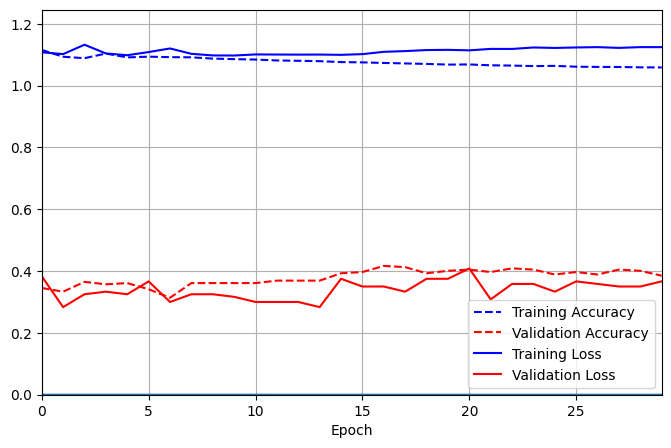

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame(history.history)

# Plotting
history_df.plot(figsize=(8, 5),
                xlim=[0, len(history_df)-1],  # Dynamic x-axis limit based on epochs
                ylim=[0, max(history_df.max())*1.1],  # Dynamic y-axis limit based on data range
                grid=True,
                xlabel="Epoch",
                style={"accuracy": "r--", "val_accuracy": "r-", "loss": "b--", "val_loss": "b-"})

# Adjusting the legend
plt.legend(["Training Accuracy", "Validation Accuracy", "Training Loss", "Validation Loss"], loc="best")
plt.show()


C) How many parameters does the network have? How many of those parameters are bias parameters? [1 points]

Flatten Layer:

Converts the 2D 64x64 input images into a 1D vector of 4096 elements.
This layer has no trainable parameters.

First Dense Layer (64 neurons):

Each of the 4096 inputs connects to each of the 64 neurons, plus each neuron has a bias term.

Weights: 4096×64= 262,144
Biases: 64

Second Dense Layer (32 neurons):
Each of the 64 outputs from the previous layer connects to each of the 32 neurons, plus each neuron has a bias term.

Weights: 64×32=2,048
Biases: 32

Third Dense Layer (8 neurons):

Each of the 32 outputs from the previous layer connects to each of the 8 neurons, plus each neuron has a bias term.
Weights: 32x8=256

Biases: 8

Output Dense Layer (3 neurons):

Each of the 8 outputs from the previous layer connects to each of the 3 output neurons, plus each neuron has a bias term.
Weights: 8×3=24
Biases: 3
Total Parameters Calculation

Total Weights = 262,144+2,048+256+24=264,472

Total Biases = 64+32+8+3=107
Total Parameters = Total Weights + Total Biases = 264,472+107=264,579

Thus, for this model architecture:
The total number of parameters is 264,579.
The number of bias parameters is 107.

**d) Compare the activity of neurons in the next to the last layer (the one with 8 neurons) with the human data. (to get human data use mds_360.txt and mds_120.txt files). Similar to before, use Procrustes analysis to do the comparison.  For training and validation data (separately), report disparity and compute the correlation coefficient between each dimension of mtx1 and mtx2. Display results in a table.**


In [34]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
from scipy.spatial import procrustes
from keras import backend as K

# Load human data
with open('/content/drive/MyDrive/mds_360.txt') as f:
    human_data_360 = np.loadtxt(f)

with open('/content/drive/MyDrive/mds_120.txt') as f:
    human_data_120 = np.loadtxt(f)

# Assume you have a trained model named 'model' and training/validation data 'X_train' and 'X_val'
# Get the output of the next-to-last layer for training and validation data
layer_index = -2  # Index of the next-to-last layer
get_layer_output = K.function([model.layers[0].input], [model.layers[layer_index].output])

# Training data
train_activations = get_layer_output([X_train])[0]

# Validation data
val_activations = get_layer_output([X_valid])[0]

# Flatten the spatial dimensions for PCA
train_activations_flat = train_activations.reshape(len(train_activations), -1)

# Apply PCA to reduce dimensionality to 8
pca = PCA(n_components=8)
train_activations_pca = pca.fit_transform(train_activations_flat)
# Flatten the spatial dimensions for PCA
val_activations_flat = val_activations.reshape(len(val_activations), -1)

# Apply PCA to reduce dimensionality to 8
val_activations_pca = pca.transform(val_activations_flat)

# Apply MDS to human data
mds = MDS(n_components=8, random_state=42)
human_data_360_mds = mds.fit_transform(human_data_360)
human_data_120_mds = mds.fit_transform(human_data_120)

# Procrustes analysis for training data
print("Shape of train_activations_pca:", train_activations_pca.shape)
print("Shape of human_data_360_mds:", human_data_360_mds.shape)

# Reshape human_data_360_mds if needed
if train_activations_pca.shape[0] != human_data_360_mds.shape[0]:
    human_data_360_mds = human_data_360_mds[:train_activations_pca.shape[0], :]

# Now, both matrices should have the same shape
disparity_train, _, train_correlations = procrustes(train_activations_pca, human_data_360_mds)
# Procrustes analysis for validation data
disparity_val, _, val_correlations = procrustes(val_activations_pca, human_data_120_mds)

# Display results in a table
print("Training Data:")
print("Disparity:", disparity_train)
print("Correlation Coefficients:")
print(train_correlations)

print("\nValidation Data:")
print("Disparity:", disparity_val)
print("Correlation Coefficients:")
print(val_correlations)

Shape of train_activations_pca: (252, 8)
Shape of human_data_360_mds: (360, 8)
Training Data:
Disparity: [[-8.68796638e-02  5.32353679e-02  9.31449429e-03 ...  9.56814784e-10
  -2.04415579e-10 -0.00000000e+00]
 [ 1.50642375e-02 -1.69204317e-03 -2.99671627e-04 ... -1.95081190e-10
  -6.93554661e-11 -0.00000000e+00]
 [ 2.67189948e-02 -4.14965244e-03  3.18720696e-02 ...  1.73592302e-08
  -7.01188520e-10  0.00000000e+00]
 ...
 [ 4.27332628e-02 -4.78337611e-02  3.93700171e-02 ... -3.50524410e-10
   1.64785236e-11  0.00000000e+00]
 [-1.72729547e-02 -3.73738527e-02  4.21013003e-02 ... -3.11599945e-10
   3.98563633e-11  0.00000000e+00]
 [-2.48437322e-02 -6.60028874e-03 -2.23072141e-02 ...  9.41479438e-11
  -2.06456148e-11  0.00000000e+00]]
Correlation Coefficients:
0.9893729323329359

Validation Data:
Disparity: [[-7.47236941e-02 -5.71667473e-02 -6.21599607e-02  1.01846690e-03
   4.19630212e-03 -9.98618014e-09  1.07118002e-09  0.00000000e+00]
 [-9.39199845e-02 -1.10224753e-01  3.60377443e-02  2